In [1]:
import pandas as pd
import numpy as np
import random
import os

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/H2GTRM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# feature importance 
def vis_feature_importances_(est, X_train):
    ftr_importances_values = est.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    plt.figure(figsize=(10,4))
    plt.title('Feature importances Top 20')
    sns.barplot(x=ftr_top20 , y = ftr_top20.index)
    plt.show()
    
# https://dacon.io/forum/401657    
def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output    

## Data Load

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# train = pd.read_csv('/content/drive/MyDrive/work/input/train.csv')
# test = pd.read_csv('/content/drive/MyDrive/work/input/test.csv')
# building_info = pd.read_csv('/content/drive/MyDrive/work/input/building_info.csv')
# submission = pd.read_csv('/content/drive/MyDrive/work/input/sample_submission.csv')
# train.shape, test.shape, building_info.shape, submission.shape

train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
building_info = pd.read_csv('input/building_info.csv')
submission = pd.read_csv('input/sample_submission.csv')
train.shape, test.shape, building_info.shape, submission.shape

((204000, 10), (16800, 7), (100, 7), (16800, 2))

## Train Data Pre-Processing

In [4]:
# 빌딩 데이터 정리
## null 처리
building_info['태양광용량(kW)'] = building_info['태양광용량(kW)'].str.replace('-','0').astype(float)
building_info['ESS저장용량(kWh)'] = building_info['ESS저장용량(kWh)'].str.replace('-','0').astype(float)
building_info['PCS용량(kW)'] = building_info['PCS용량(kW)'].str.replace('-','0').astype(float)

In [5]:
# 정리된 빌딩과 merge
train = train.merge(building_info, on='건물번호')
test = test.merge(building_info, on='건물번호')

In [6]:
#시계열 특성을 학습에 반영하기 위해 일시를 월, 일, 시간으로 나눕니다
train['month'] = train['일시'].apply(lambda x : int(x[4:6]))
train['day'] = train['일시'].apply(lambda x : int(x[6:8]))
train['time'] = train['일시'].apply(lambda x : int(x[9:11]))

test['month'] = test['일시'].apply(lambda x : int(x[4:6]))
test['day'] = test['일시'].apply(lambda x : int(x[6:8]))
test['time'] = test['일시'].apply(lambda x : int(x[9:11]))

In [7]:
# 요일
train['weekday'] =  pd.to_datetime(train['일시'].str[:8]).dt.weekday
test['weekday'] =  pd.to_datetime(test['일시'].str[:8]).dt.weekday

In [8]:
# outlier 제거 
train = train[train['전력소비량(kWh)'] > 1]

In [9]:
target_encoding = train.groupby(['건물유형']).agg({'전력소비량(kWh)':['min', 'mean','max']}).reset_index()
target_encoding.columns = ['건물유형', 'khw_min', 'khw_mean', 'khw_max']
train = train.merge(target_encoding, on=['건물유형'], how='left')
test = test.merge(target_encoding, on=['건물유형'], how='left')

In [10]:
train.drop( train[(train['건물번호'].isin([1,16])) & (train['month'] == 6)].index, inplace=True)

In [11]:
no_work_day = train.groupby(['건물번호', '건물유형','month', 'day']).agg({'전력소비량(kWh)':['mean','max']}).reset_index()
no_work_day.columns = ['건물번호', '건물유형','month', 'day', 'khw_mean', 'khw_max']
total_mean = no_work_day[no_work_day['건물유형'].isin(['백화점및아울렛','할인마트'])].groupby(['건물번호']).khw_mean.mean().reset_index().rename(columns={'khw_mean':'b_mean'})

no_work_day = no_work_day.merge(total_mean, on='건물번호')
no_work_day.loc[no_work_day.b_mean > no_work_day.khw_max, '백화점휴무일'] = 1

train = train.merge(no_work_day[['건물번호', '건물유형','month', 'day', '백화점휴무일']], on=['건물번호', '건물유형','month', 'day'], how='left')
train['백화점휴무일'] = train['백화점휴무일'].fillna(0).astype(int)
test['백화점휴무일'] = 0

In [12]:
train['냉방비율'] = ((train['냉방면적(m2)'] / train['연면적(m2)'])*100 ).astype(int)
test['냉방비율'] = ((test['냉방면적(m2)'] / test['연면적(m2)'])*100 ).astype(int)

train = train.drop(columns=['연면적(m2)','냉방면적(m2)'])
test = test.drop(columns=['연면적(m2)','냉방면적(m2)'])

In [13]:
#결측값을 0으로 채웁니다
train = train.fillna(0)
test = test.fillna(0)

In [14]:
# train['풍속(m/s)'] = 0
# train.loc[train['건물유형'].isin(['호텔및리조트','백화점및아울렛']), '풍속(m/s)'] = 0

In [15]:
train.drop('풍속(m/s)', axis=1, inplace=True)
test.drop('풍속(m/s)', axis=1, inplace=True)

In [16]:
# 공휴일 제외 
print(train.shape)
train['dates'] = train['일시'].apply(lambda x : int(x[:8]))
# train = train[~((train['dates'].isin([20220606,20220615])) & (train['건물유형'].isin(['공공','병원'])))]
train['holiday'] = 0
test['holiday'] = 0
train.loc[train['dates'].isin([20220606,20220615]), 'holiday'] = 1

train.drop(['dates'], axis=1, inplace=True)
train.shape

(202558, 22)


(202558, 23)

In [17]:
## https://dacon.io/competitions/official/235736/codeshare/2743?page=1&dtype=recent
train['THI'] = 9/5*train['기온(C)'] - 0.55*(1-train['습도(%)']/100)*(9/5*train['습도(%)']-26)+32
test['THI'] = 9/5*test['기온(C)'] - 0.55*(1-test['습도(%)']/100)*(9/5*test['습도(%)']-26)+32

In [18]:
def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

cdhs = np.array([])

for num in train['건물번호'].unique():
    temp = train[train['건물번호'] == num]
    cdh = CDH(temp['기온(C)'].values)
    cdhs = np.concatenate([cdhs, cdh])
train['CDH'] = cdhs

cdhs = np.array([])
for num in test['건물번호'].unique():
    temp = test[test['건물번호'] == num]
    cdh = CDH(temp['기온(C)'].values)
    cdhs = np.concatenate([cdhs, cdh])
test['CDH'] = cdhs

In [19]:
# train_x = train.drop(columns=['num_date_time', '일시', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'])
# train_y = train['전력소비량(kWh)']

# test_x = test.drop(columns=['num_date_time', '일시'])

# X_train, X_test, y_train, y_test = train_test_split(train_x , train_y ,test_size=0.2, shuffle=True, random_state=42, stratify=train_x['건물번호'])
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [20]:
days = [18, 19, 20, 21, 22, 23, 24]

X_train = train[~((train['month'] == 8) & (train['day'].isin(days)))].drop(columns=['num_date_time', '일시', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'])
y_train = train[~((train['month'] == 8) & (train['day'].isin(days)))]['전력소비량(kWh)']

X_test = train[(train['month'] == 8) & (train['day'].isin(days))].drop(columns=['num_date_time', '일시', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'])
y_test = train[(train['month'] == 8) & (train['day'].isin(days))]['전력소비량(kWh)']


print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(185758, 20) (16800, 20) (185758,) (16800,)


In [21]:
#결측값을 0으로 채웁니다
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

## Regression Model Fit

,건물유형,유형별_score
0,건물기타,6.961784


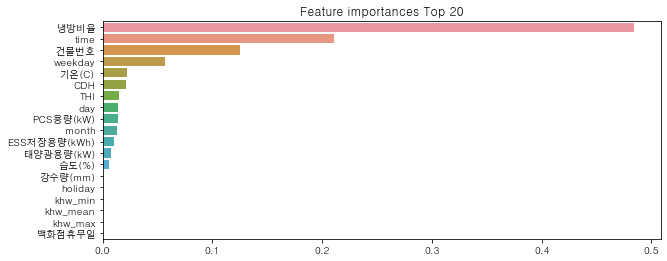

,건물유형,유형별_score
0,공공,6.39235


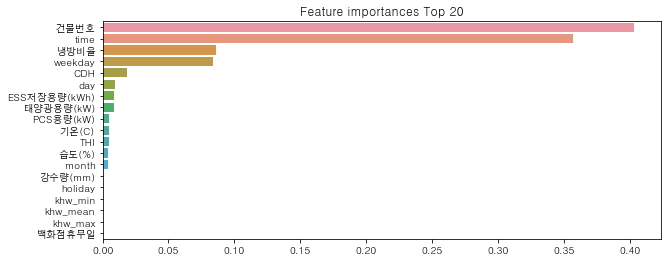

,건물유형,유형별_score
0,대학교,4.387156


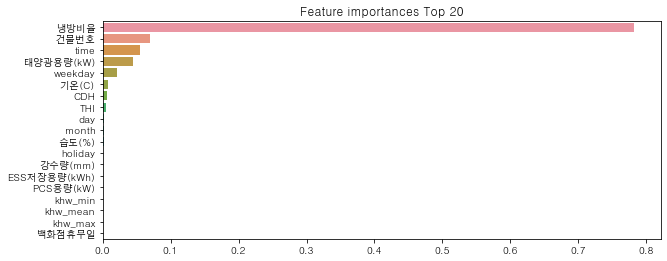

,건물유형,유형별_score
0,데이터센터,0.570914


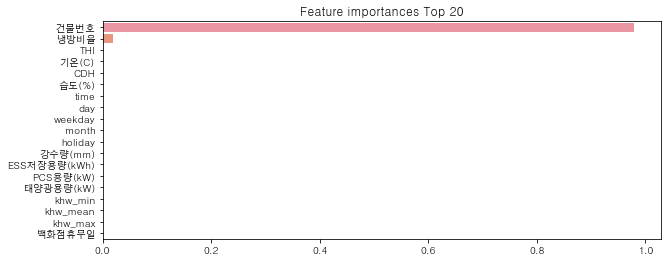

,건물유형,유형별_score
0,백화점및아울렛,4.84909


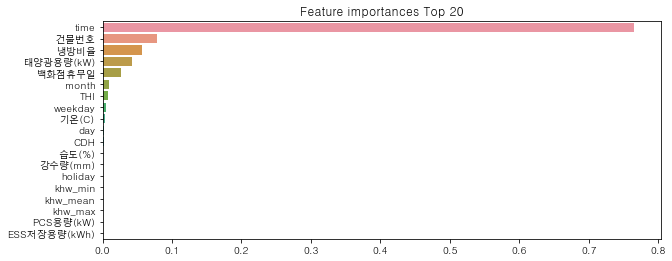

,건물유형,유형별_score
0,병원,4.018155


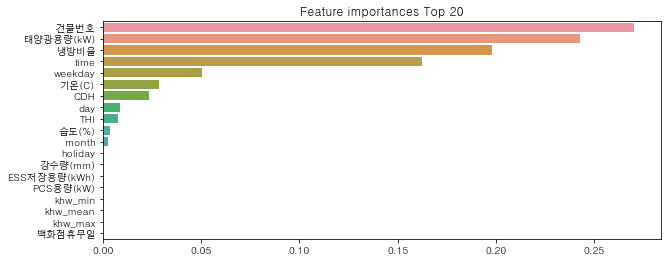

,건물유형,유형별_score
0,상용,6.831948


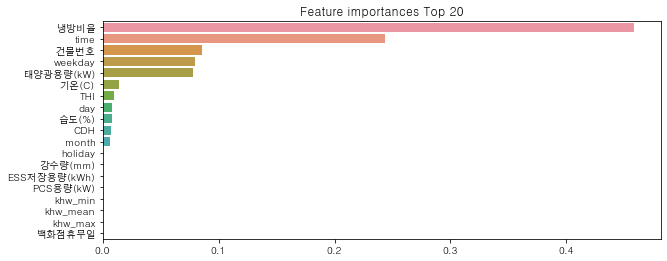

,건물유형,유형별_score
0,아파트,5.675344


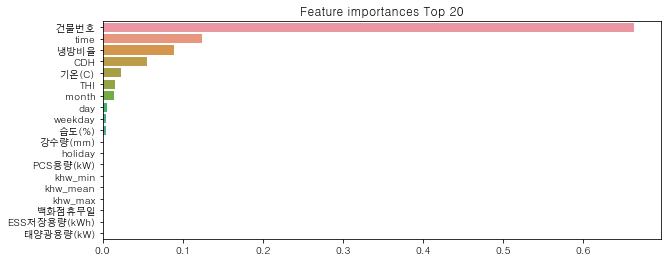

,건물유형,유형별_score
0,연구소,5.540178


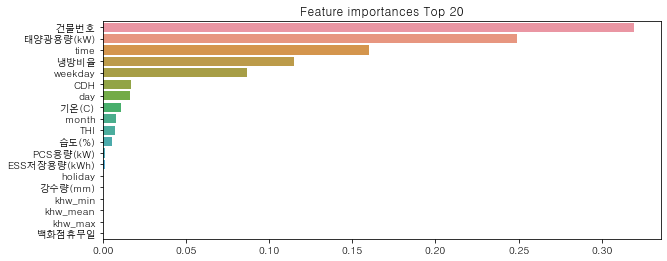

,건물유형,유형별_score
0,지식산업센터,3.971259


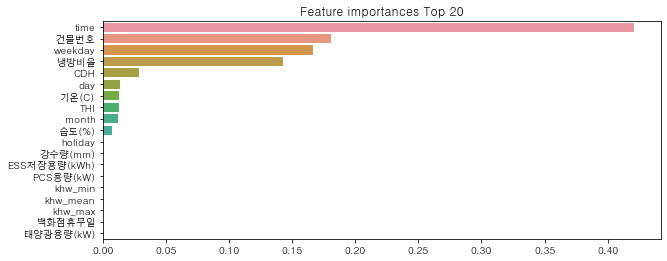

,건물유형,유형별_score
0,할인마트,5.768469


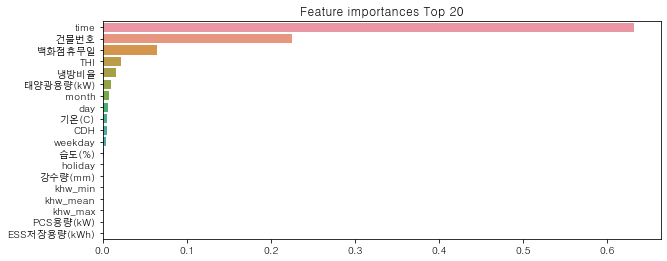

,건물유형,유형별_score
0,호텔및리조트,7.747355


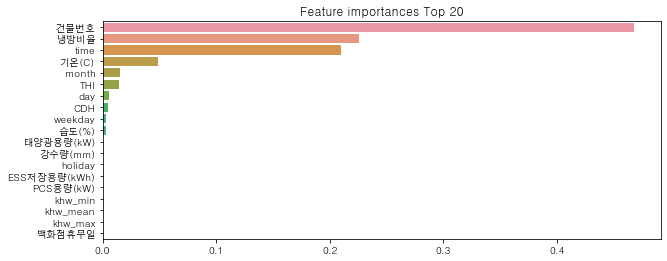

Wall time: 1min 18s


In [22]:
%%time 
metrics_type = pd.DataFrame()
for i in train['건물유형'].unique():
    temp_X_train = X_train[X_train['건물유형'] == i].drop(['건물유형'], axis=1)
    temp_y_train = y_train.loc[temp_X_train.index]
    temp_X_test = X_test[X_test['건물유형'] == i].drop(['건물유형'], axis=1)
    temp_y_test = y_test.loc[temp_X_test.index]
    
    model = RandomForestRegressor(random_state=42)
    model.fit(temp_X_train, temp_y_train)
    y_preds = model.predict(temp_X_test)
    
    temp = pd.DataFrame([i, smape(temp_y_test, y_preds)]).T
    temp.columns = ['건물유형', '유형별_score']
    metrics_type = metrics_type.append(temp)
    display(temp)
    vis_feature_importances_(model, temp_X_train)    
    

,건물번호,건물별_score
0,1.0,6.230321


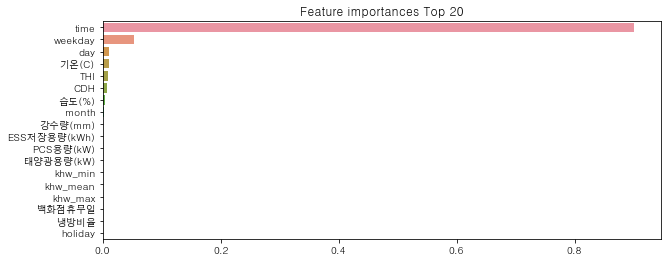

,건물번호,건물별_score
0,2.0,8.112875


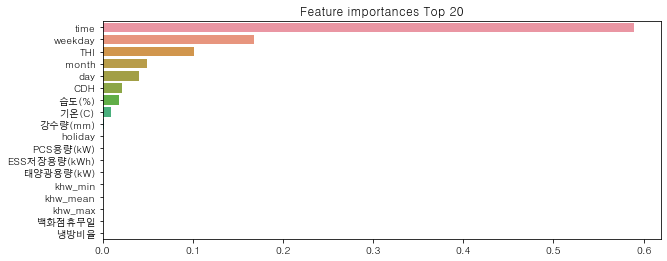

,건물번호,건물별_score
0,3.0,8.867619


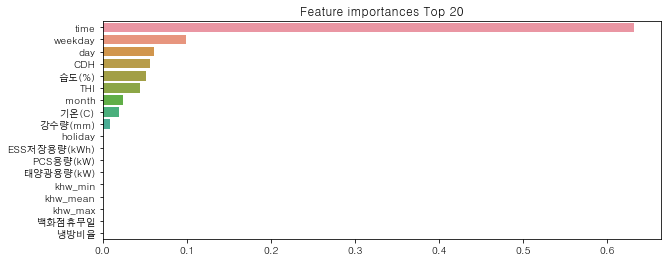

,건물번호,건물별_score
0,4.0,4.742387


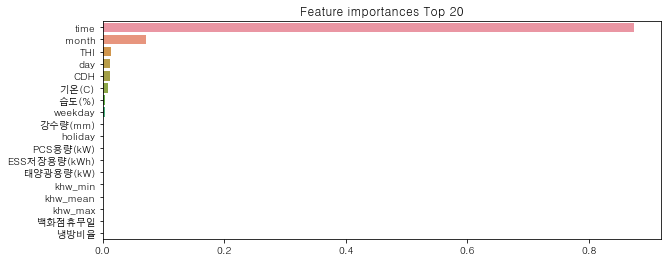

,건물번호,건물별_score
0,5.0,6.089214


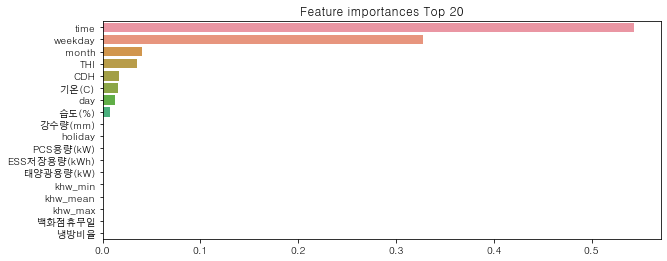

,건물번호,건물별_score
0,6.0,4.580888


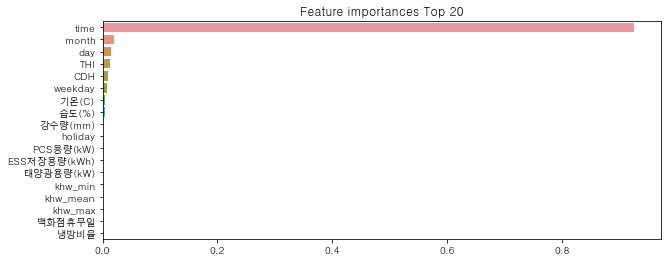

,건물번호,건물별_score
0,7.0,8.114238


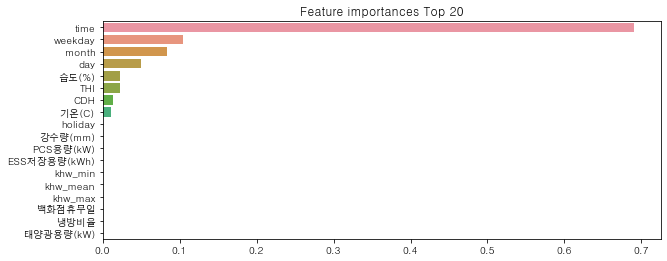

,건물번호,건물별_score
0,8.0,5.015907


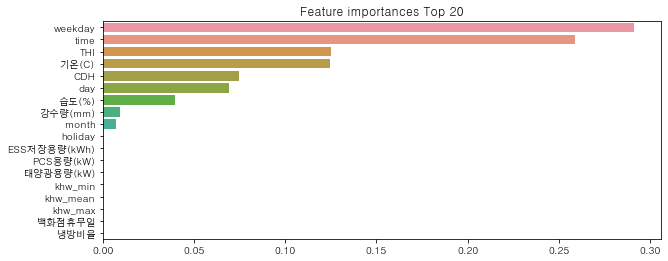

,건물번호,건물별_score
0,9.0,4.918699


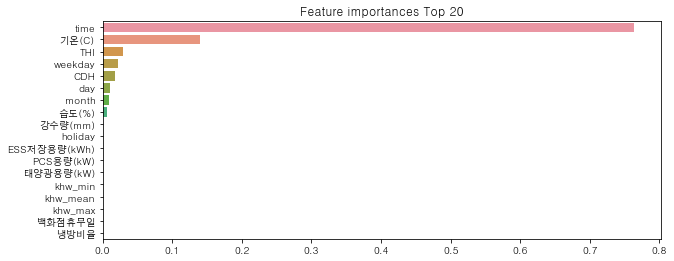

,건물번호,건물별_score
0,10.0,10.554409


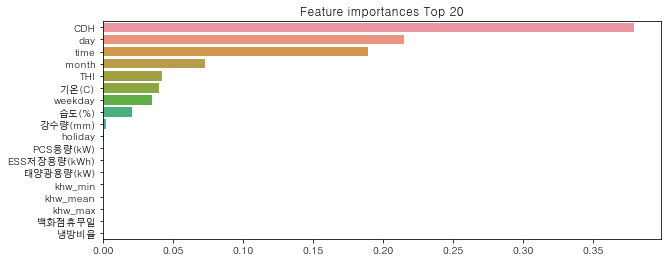

,건물번호,건물별_score
0,11.0,3.570962


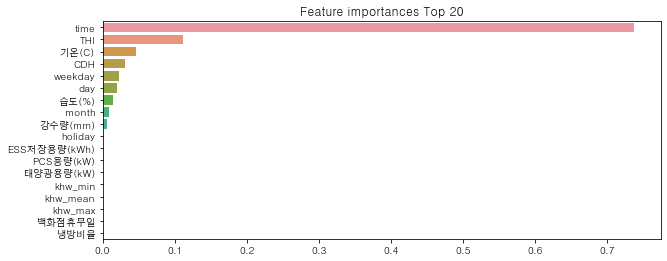

,건물번호,건물별_score
0,12.0,4.89129


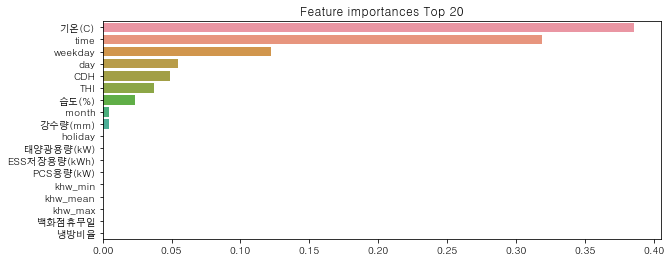

,건물번호,건물별_score
0,13.0,6.724624


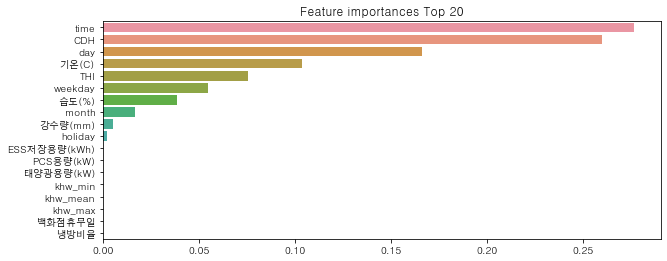

,건물번호,건물별_score
0,14.0,17.04126


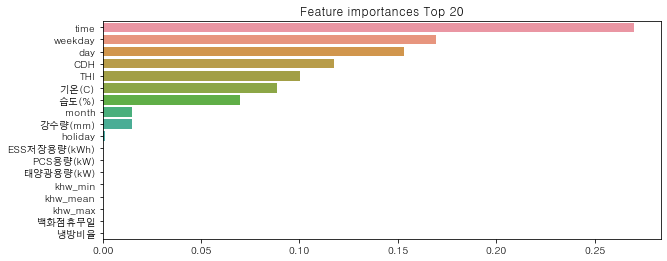

,건물번호,건물별_score
0,15.0,3.106067


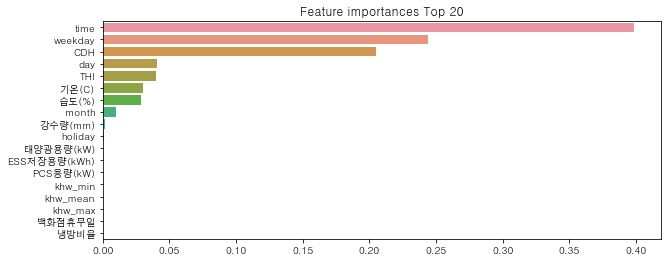

,건물번호,건물별_score
0,16.0,4.843233


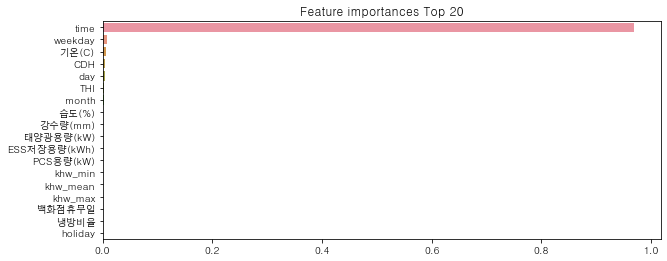

,건물번호,건물별_score
0,17.0,7.819162


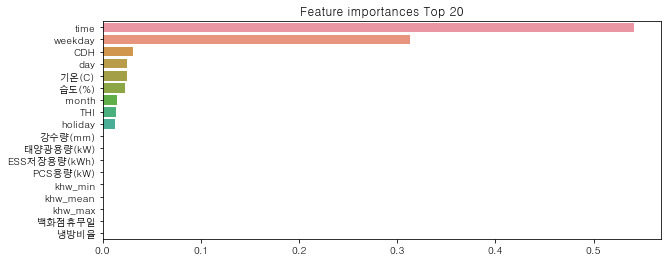

,건물번호,건물별_score
0,18.0,7.236058


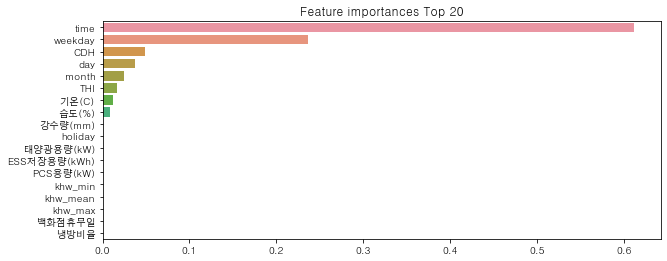

,건물번호,건물별_score
0,19.0,11.137112


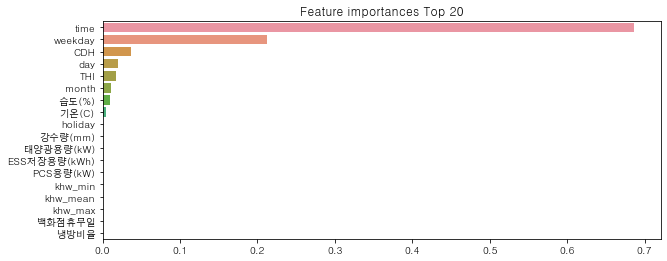

,건물번호,건물별_score
0,20.0,6.263314


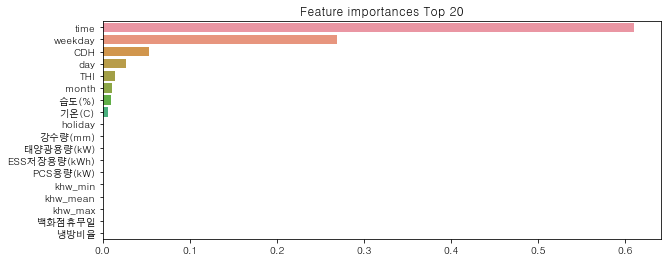

,건물번호,건물별_score
0,21.0,7.472028


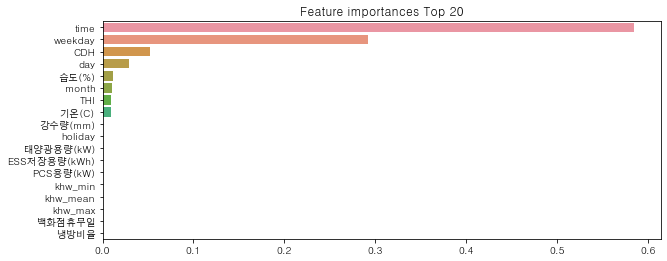

,건물번호,건물별_score
0,22.0,4.363676


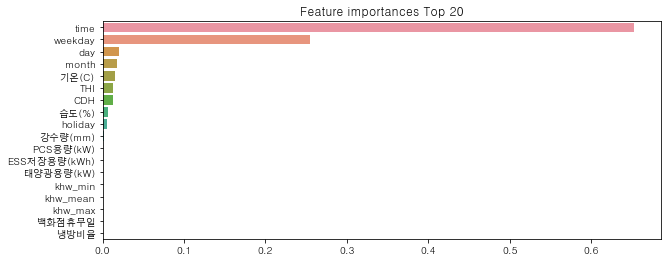

,건물번호,건물별_score
0,23.0,2.134704


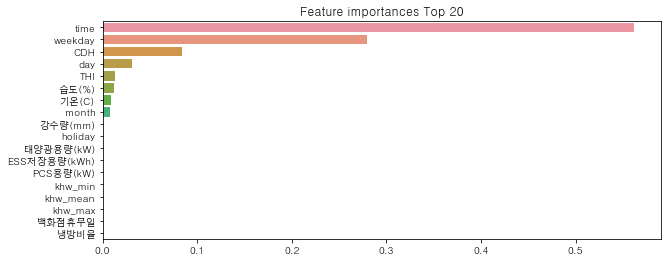

,건물번호,건물별_score
0,24.0,2.412195


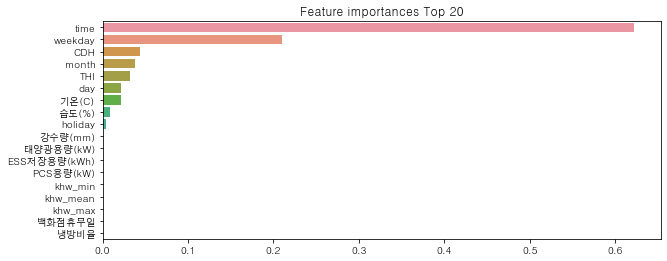

,건물번호,건물별_score
0,25.0,2.677489


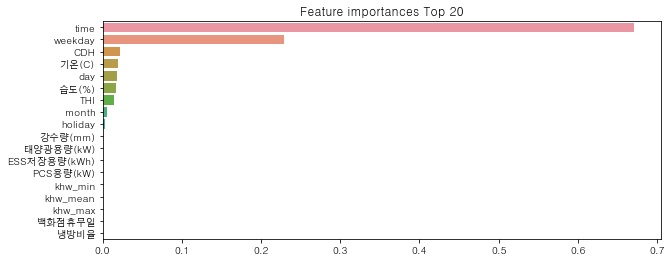

,건물번호,건물별_score
0,26.0,2.663694


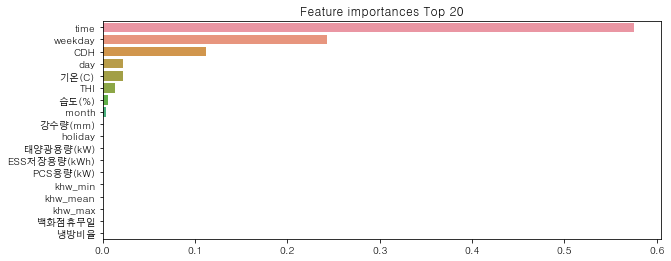

,건물번호,건물별_score
0,27.0,2.460976


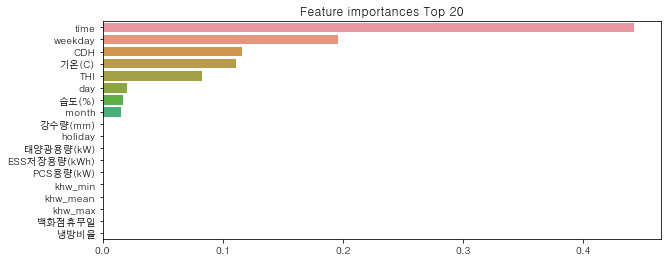

,건물번호,건물별_score
0,28.0,6.801047


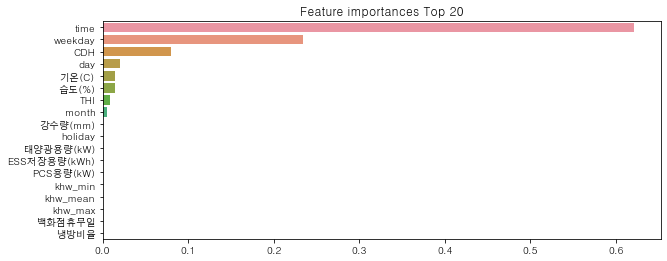

,건물번호,건물별_score
0,29.0,5.171928


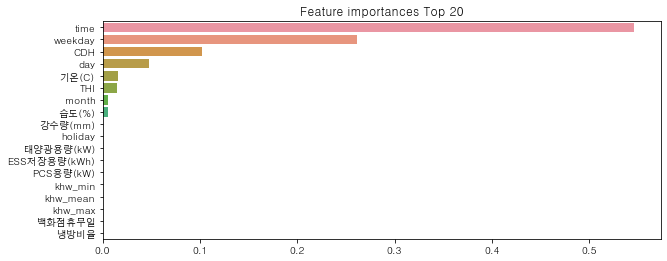

,건물번호,건물별_score
0,30.0,8.019409


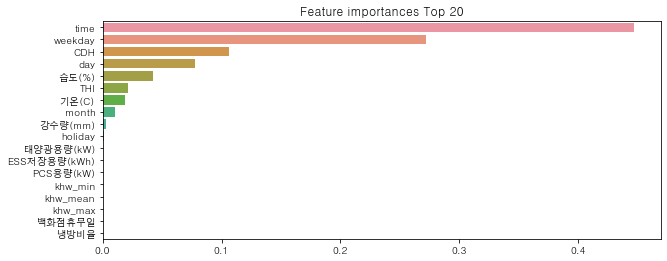

,건물번호,건물별_score
0,31.0,5.545601


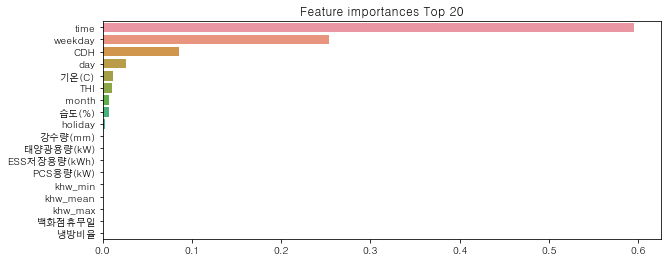

,건물번호,건물별_score
0,32.0,0.486998


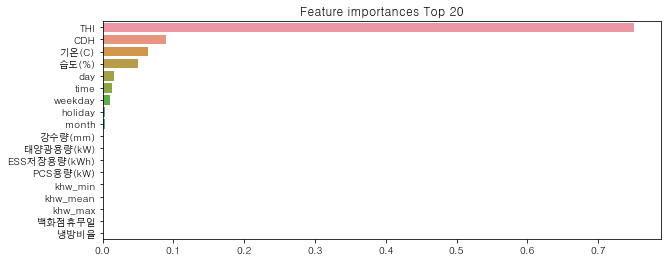

,건물번호,건물별_score
0,33.0,0.52057


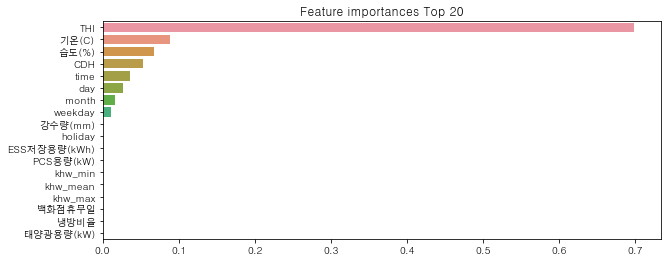

,건물번호,건물별_score
0,34.0,0.735511


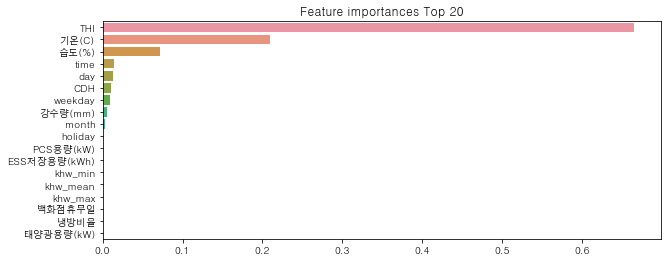

,건물번호,건물별_score
0,35.0,0.480114


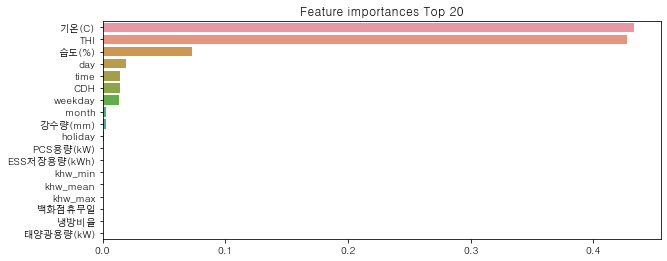

,건물번호,건물별_score
0,36.0,0.625575


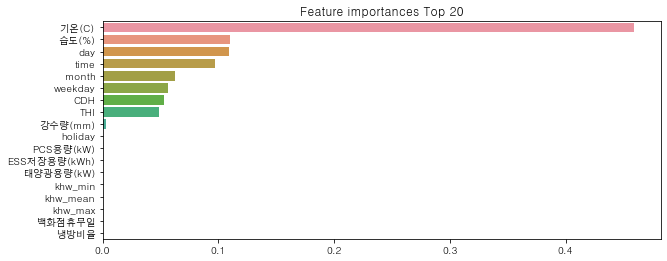

,건물번호,건물별_score
0,37.0,3.897871


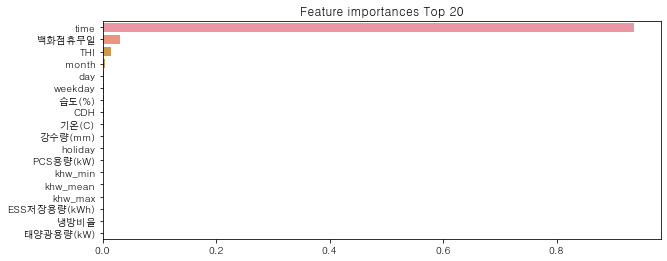

,건물번호,건물별_score
0,38.0,3.620875


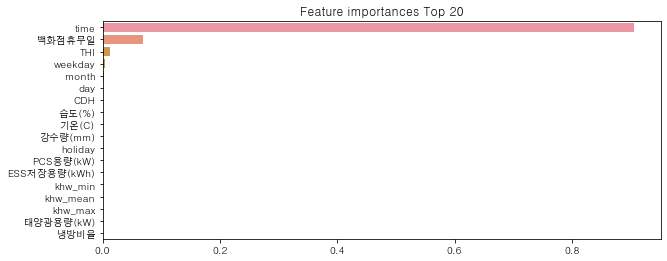

,건물번호,건물별_score
0,39.0,4.16221


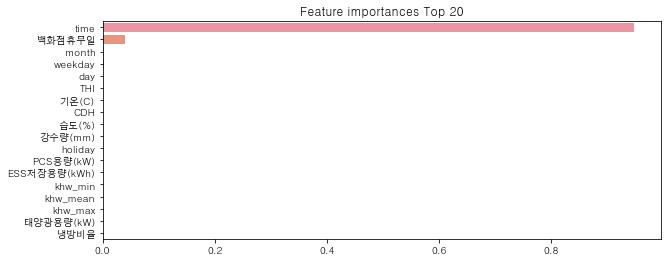

,건물번호,건물별_score
0,40.0,9.96141


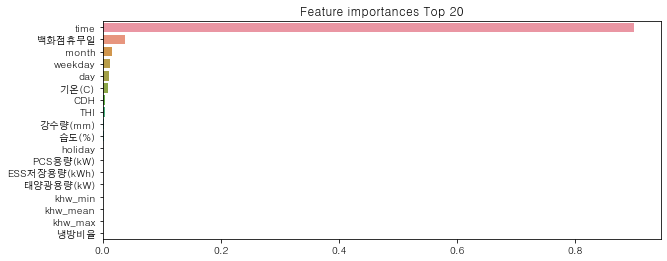

,건물번호,건물별_score
0,41.0,4.207855


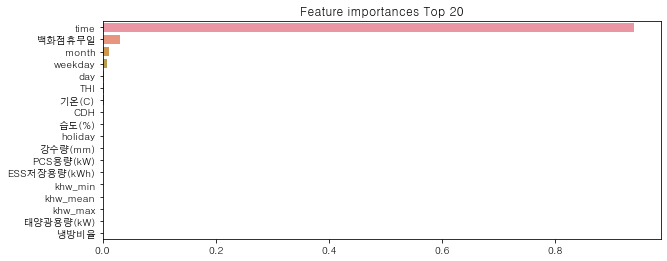

,건물번호,건물별_score
0,42.0,5.13885


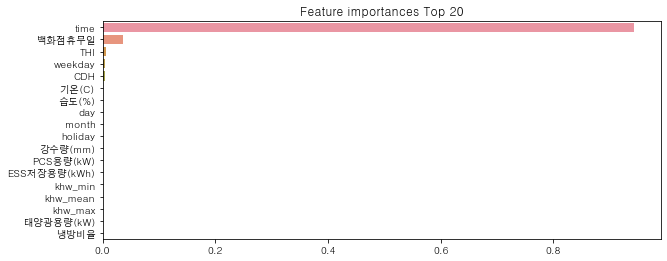

,건물번호,건물별_score
0,43.0,5.390333


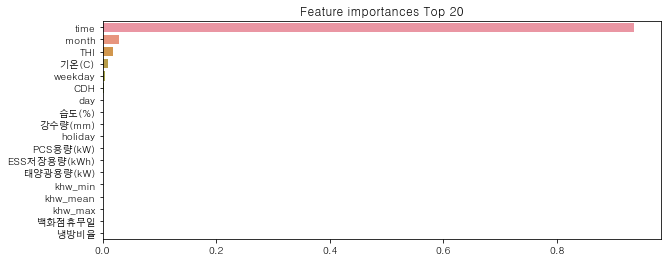

,건물번호,건물별_score
0,44.0,4.079417


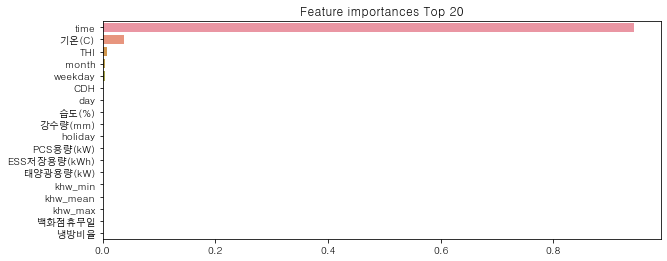

,건물번호,건물별_score
0,45.0,2.93291


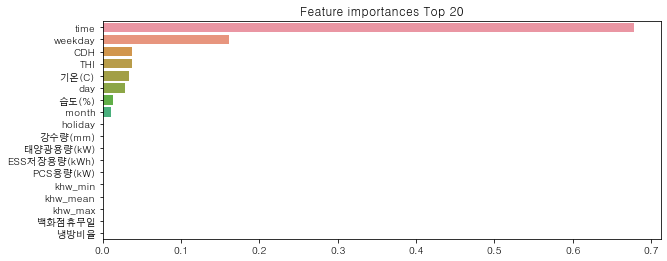

,건물번호,건물별_score
0,46.0,6.519264


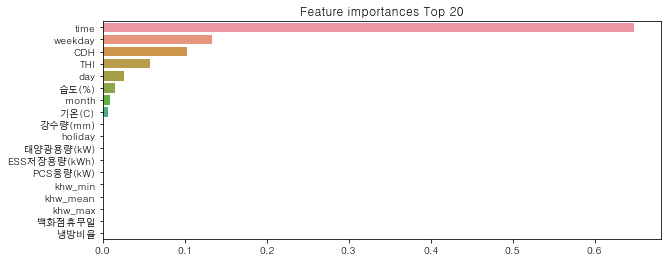

,건물번호,건물별_score
0,47.0,4.863776


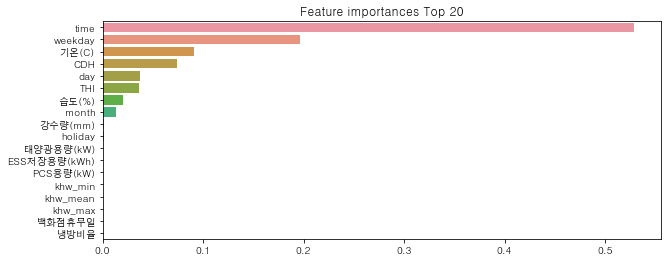

,건물번호,건물별_score
0,48.0,2.729423


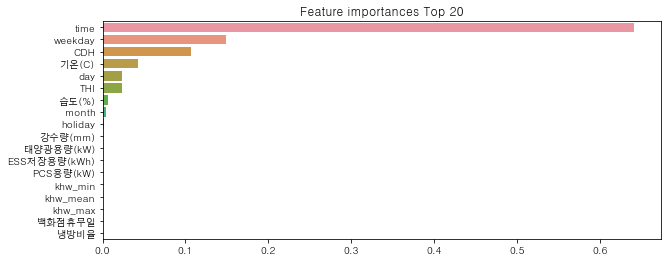

,건물번호,건물별_score
0,49.0,4.070149


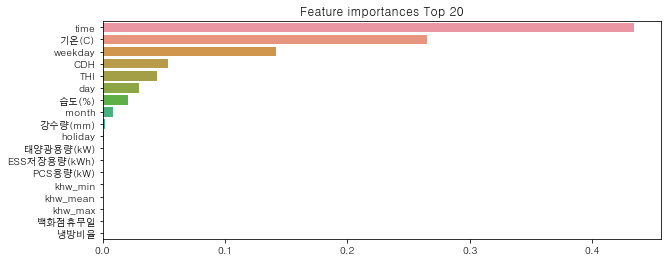

,건물번호,건물별_score
0,50.0,2.909443


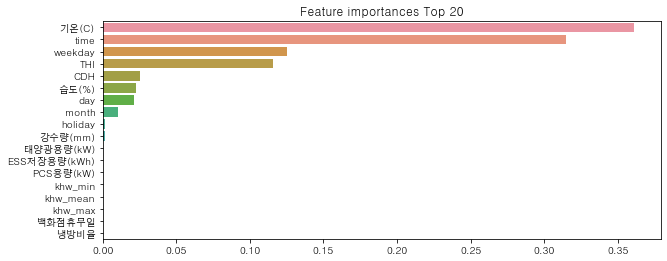

,건물번호,건물별_score
0,51.0,5.041036


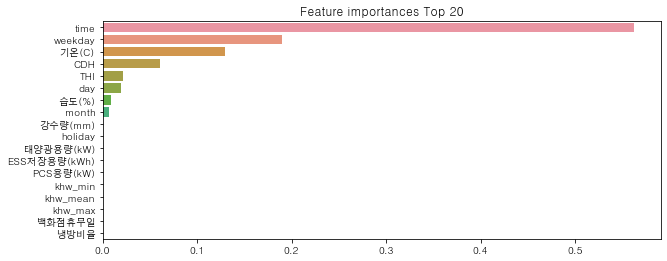

,건물번호,건물별_score
0,52.0,3.960904


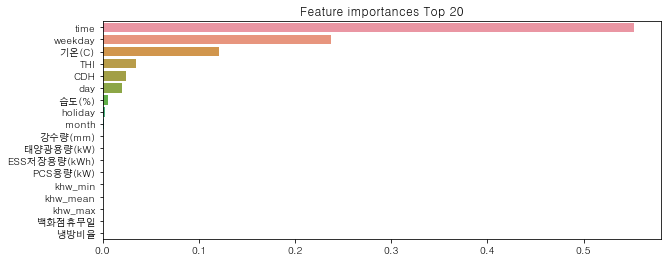

,건물번호,건물별_score
0,53.0,12.432484


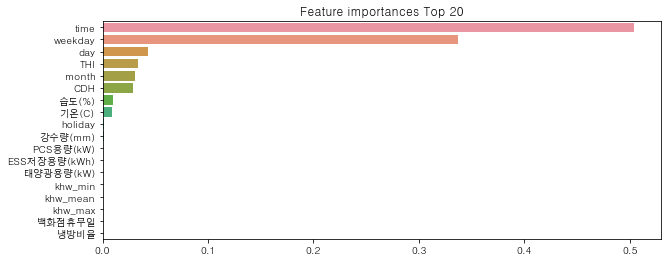

,건물번호,건물별_score
0,54.0,21.802356


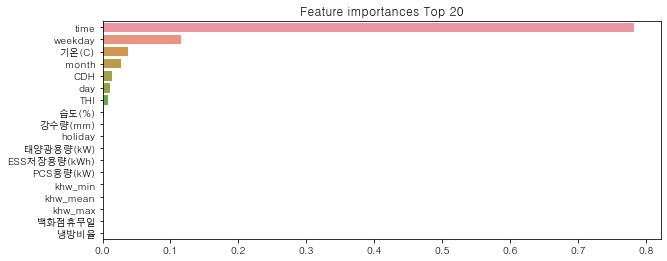

,건물번호,건물별_score
0,55.0,1.711004


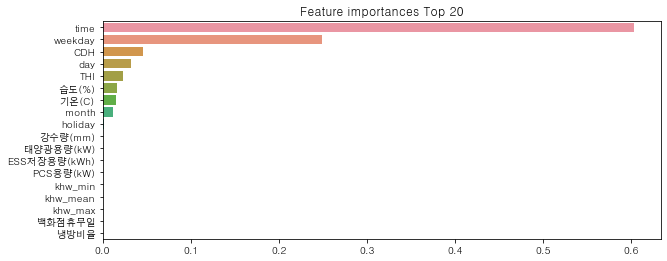

,건물번호,건물별_score
0,56.0,1.335512


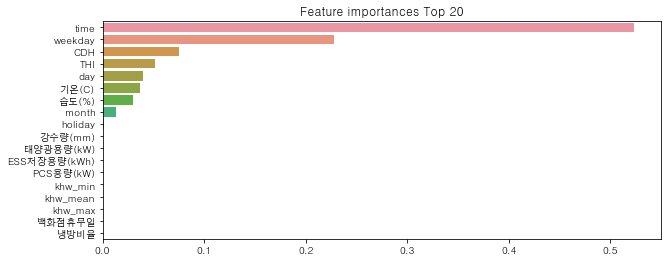

,건물번호,건물별_score
0,57.0,5.272747


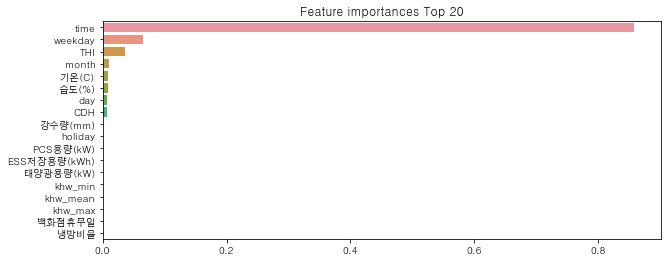

,건물번호,건물별_score
0,58.0,0.450957


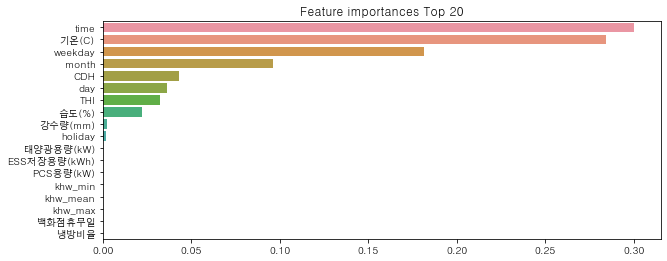

,건물번호,건물별_score
0,59.0,6.270178


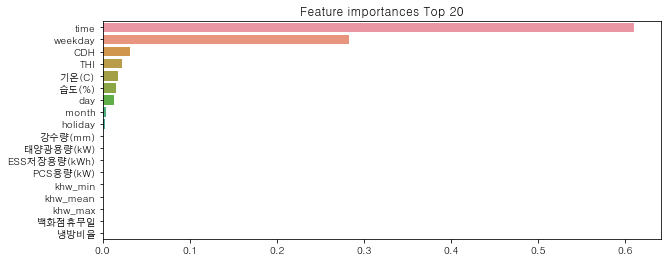

,건물번호,건물별_score
0,60.0,5.258124


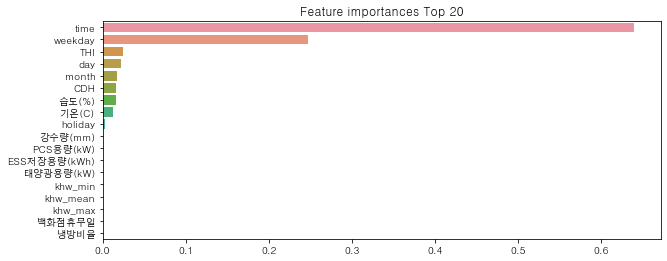

,건물번호,건물별_score
0,61.0,4.801637


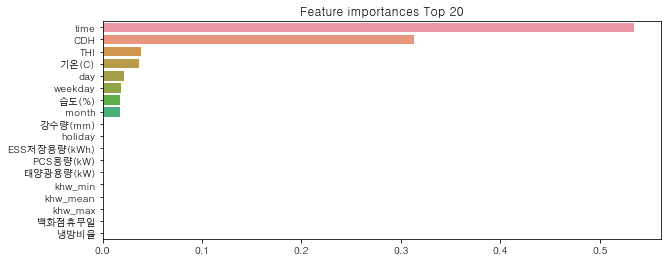

,건물번호,건물별_score
0,62.0,5.211021


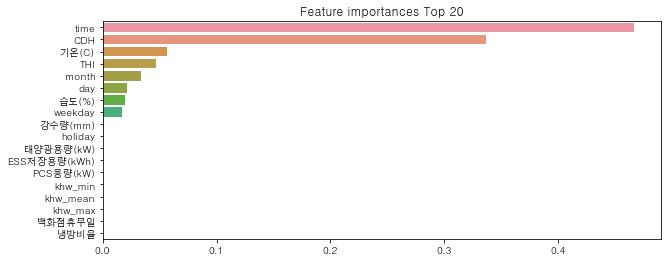

,건물번호,건물별_score
0,63.0,5.754098


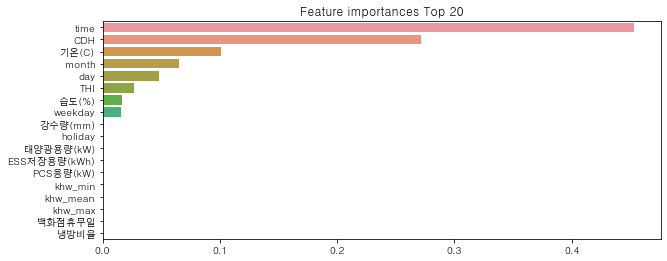

,건물번호,건물별_score
0,64.0,3.74359


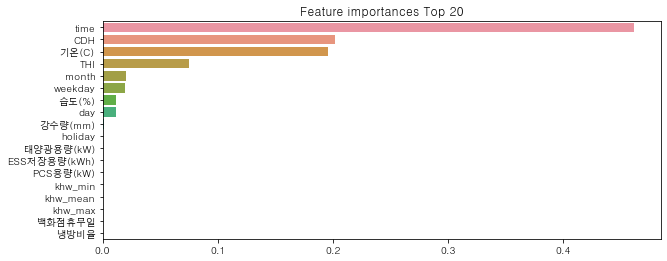

,건물번호,건물별_score
0,65.0,8.661674


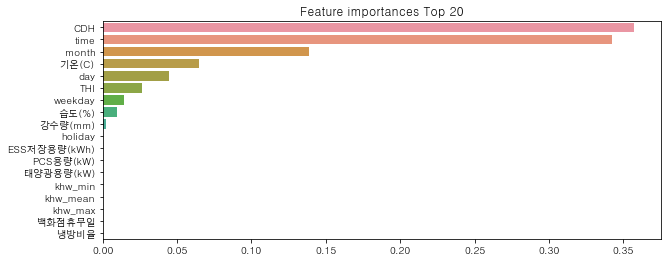

,건물번호,건물별_score
0,66.0,6.472589


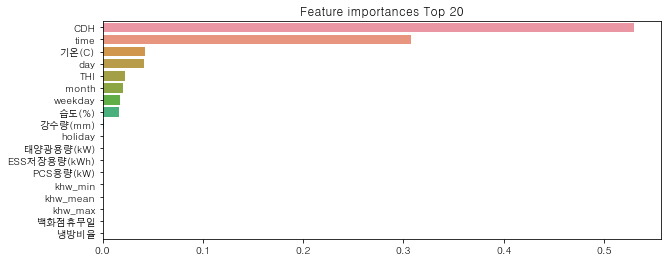

,건물번호,건물별_score
0,67.0,5.795349


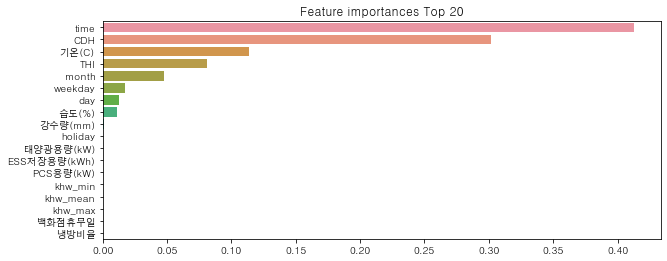

,건물번호,건물별_score
0,68.0,4.08078


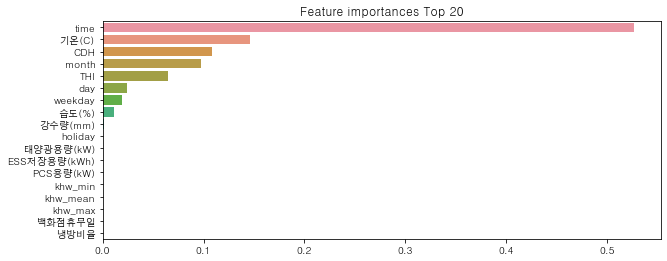

,건물번호,건물별_score
0,69.0,2.821002


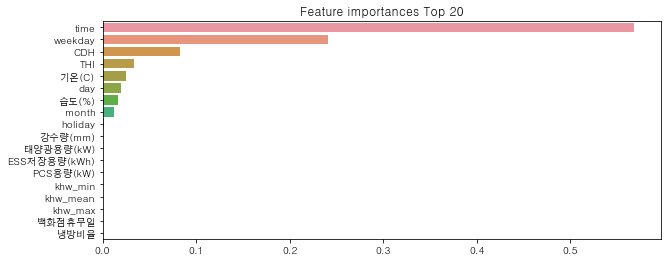

,건물번호,건물별_score
0,70.0,4.41781


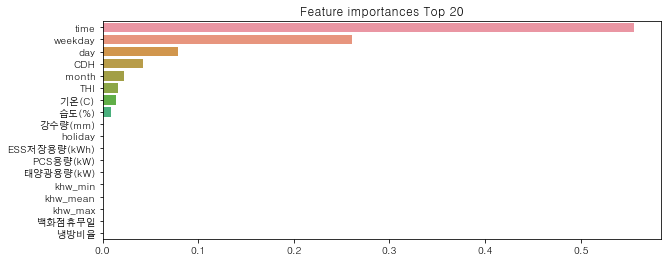

,건물번호,건물별_score
0,71.0,5.671063


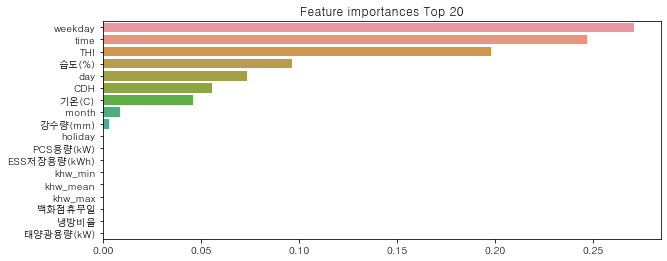

,건물번호,건물별_score
0,72.0,8.105109


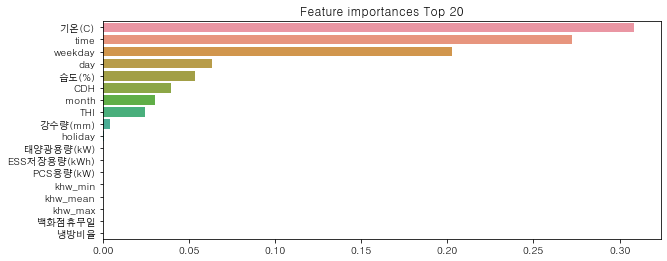

,건물번호,건물별_score
0,73.0,4.11721


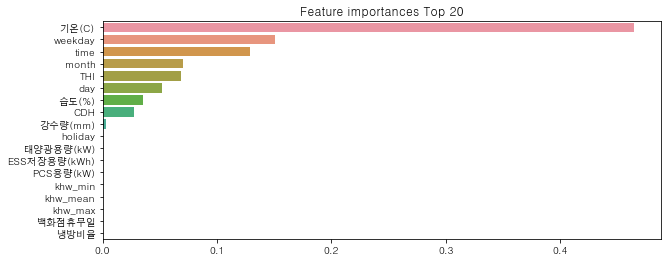

,건물번호,건물별_score
0,74.0,7.018712


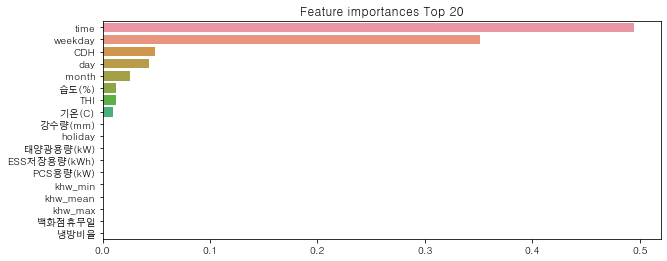

,건물번호,건물별_score
0,75.0,4.597657


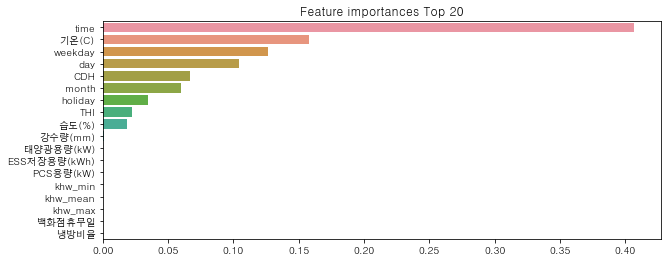

,건물번호,건물별_score
0,76.0,4.953788


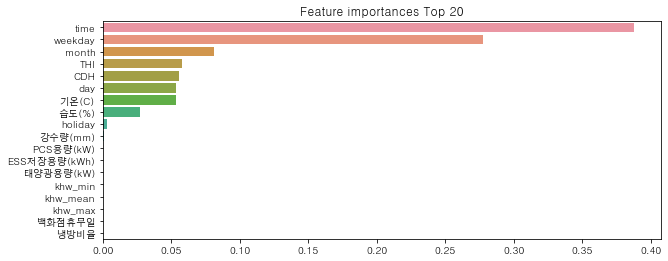

,건물번호,건물별_score
0,77.0,2.605448


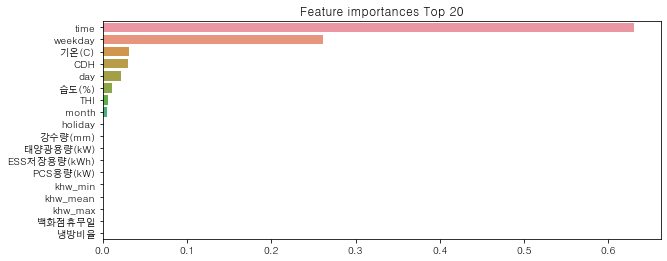

,건물번호,건물별_score
0,78.0,4.713826


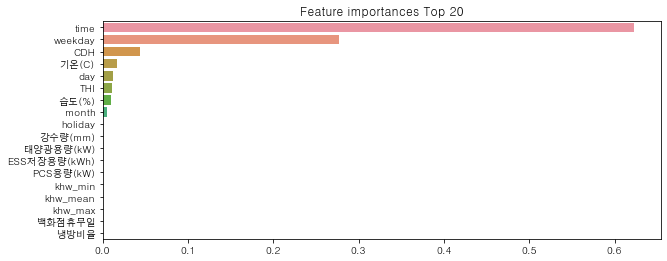

,건물번호,건물별_score
0,79.0,3.991984


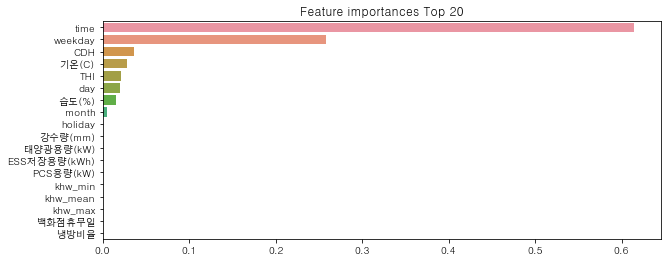

,건물번호,건물별_score
0,80.0,4.496099


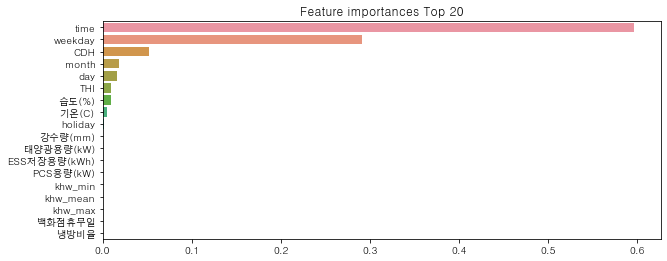

,건물번호,건물별_score
0,81.0,3.608905


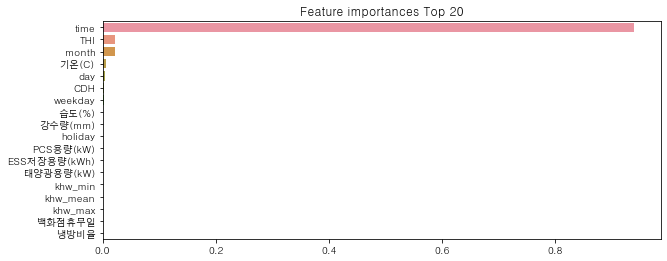

,건물번호,건물별_score
0,82.0,4.084912


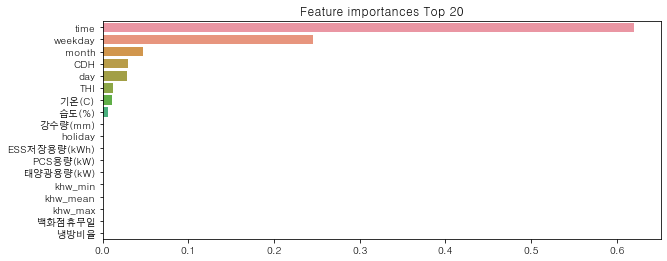

,건물번호,건물별_score
0,83.0,3.139627


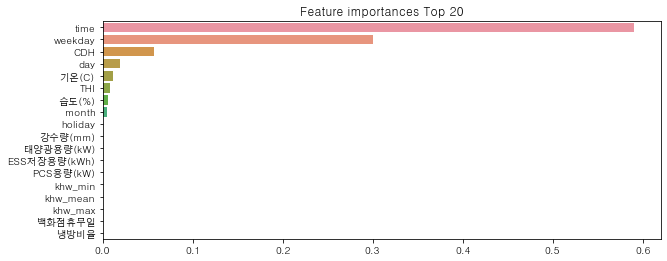

,건물번호,건물별_score
0,84.0,2.96407


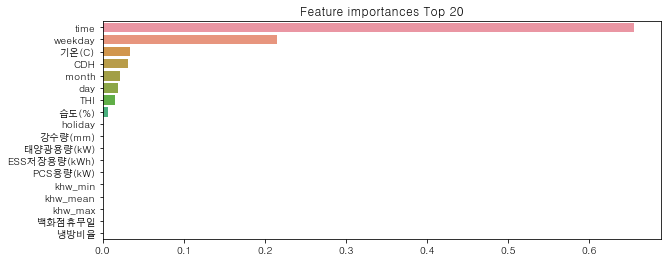

,건물번호,건물별_score
0,85.0,4.443806


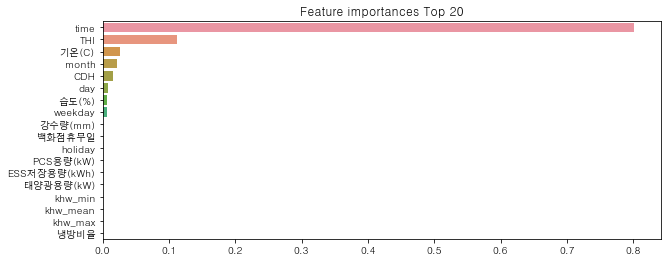

,건물번호,건물별_score
0,86.0,4.266903


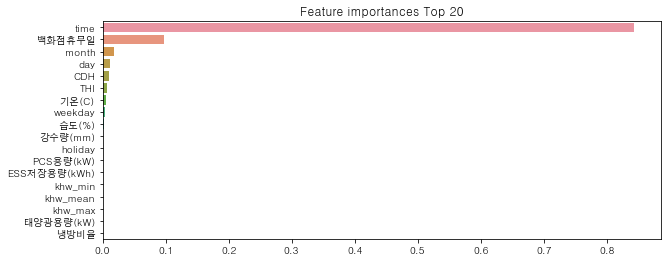

,건물번호,건물별_score
0,87.0,9.539037


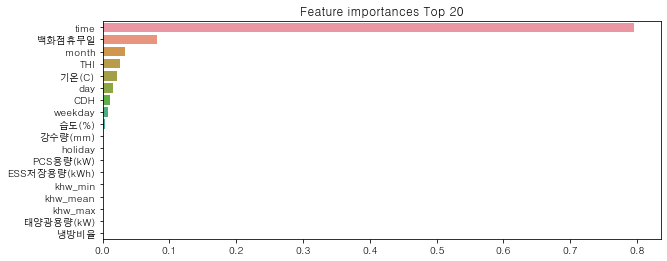

,건물번호,건물별_score
0,88.0,3.56788


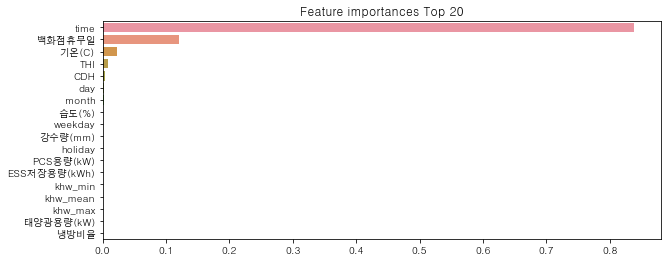

,건물번호,건물별_score
0,89.0,4.041812


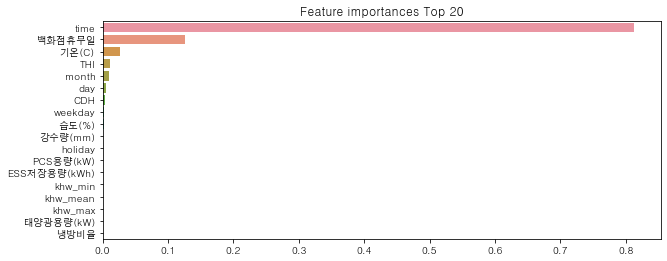

,건물번호,건물별_score
0,90.0,4.448625


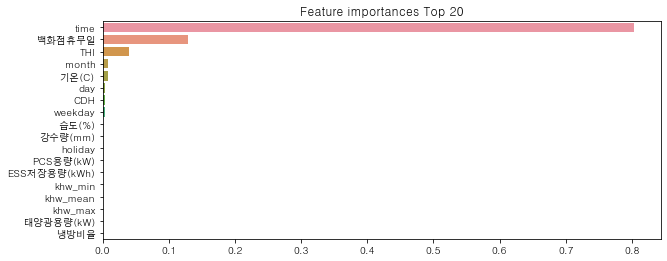

,건물번호,건물별_score
0,91.0,11.735458


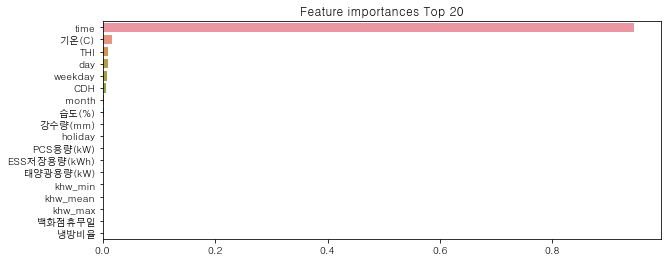

,건물번호,건물별_score
0,92.0,4.751536


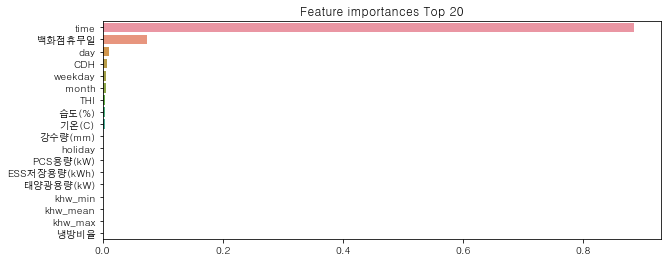

,건물번호,건물별_score
0,93.0,6.68421


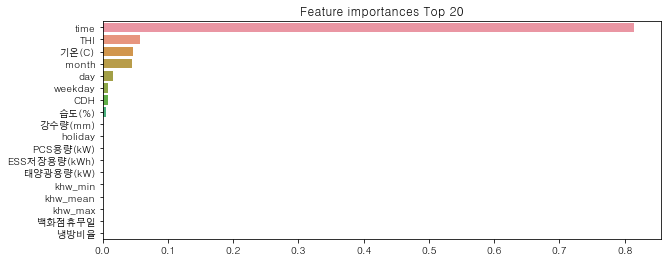

,건물번호,건물별_score
0,94.0,6.997837


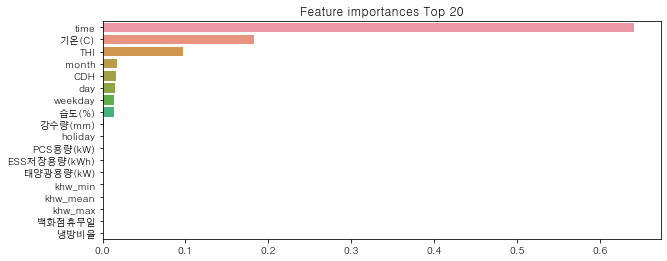

,건물번호,건물별_score
0,95.0,16.846126


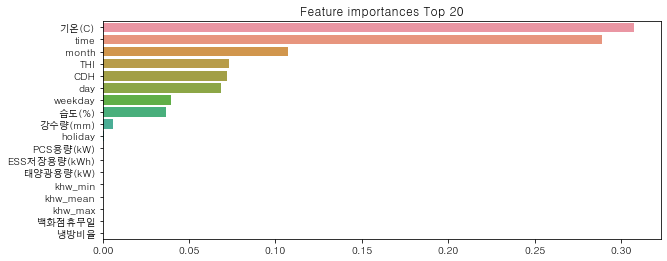

,건물번호,건물별_score
0,96.0,3.756591


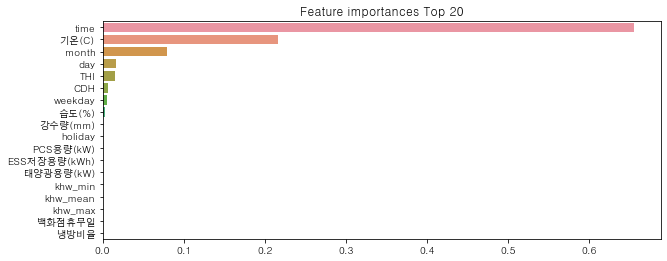

,건물번호,건물별_score
0,97.0,6.611036


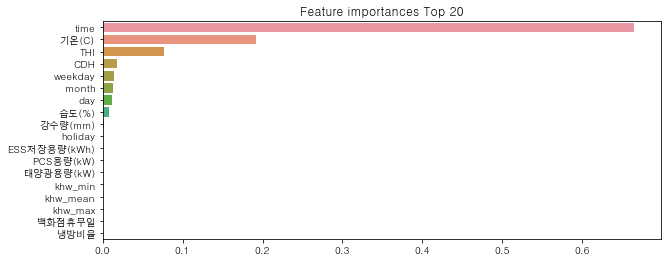

,건물번호,건물별_score
0,98.0,13.678409


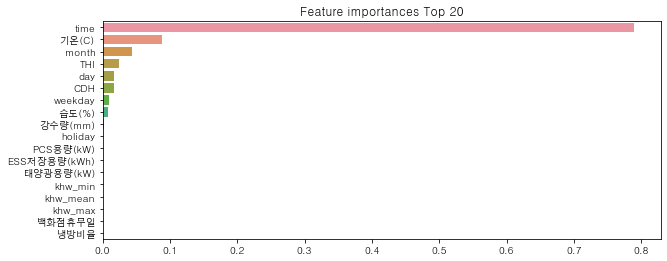

,건물번호,건물별_score
0,99.0,4.13152


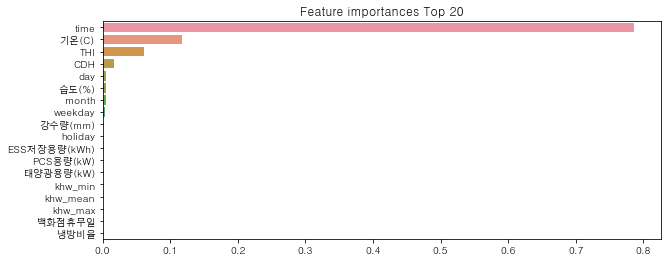

,건물번호,건물별_score
0,100.0,5.888441


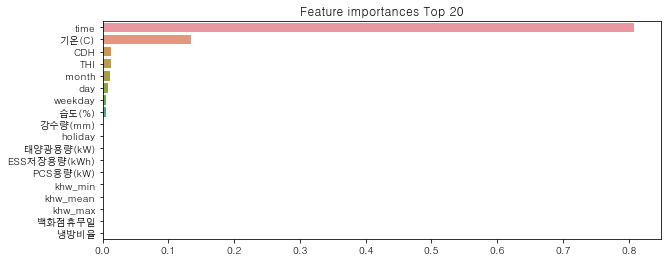


Wall time: 1min 32s


In [23]:
%%time 
metrics_bno = pd.DataFrame()
for i in train['건물번호'].unique():

    temp_X_train = X_train[X_train['건물번호'] == i].drop(['건물번호','건물유형'], axis=1)
    temp_y_train = y_train.loc[temp_X_train.index]
    temp_X_test = X_test[X_test['건물번호'] == i].drop(['건물번호','건물유형'], axis=1)
    temp_y_test = y_test.loc[temp_X_test.index]
        
    model = RandomForestRegressor(random_state=42)
    model.fit(temp_X_train, temp_y_train)
    y_preds = model.predict(temp_X_test)
    
    temp = pd.DataFrame([i, smape(temp_y_test, y_preds)]).T
    temp.columns = ['건물번호', '건물별_score']
    metrics_bno = metrics_bno.append(temp)
    display(temp)
    vis_feature_importances_(model, temp_X_train)    
    print()

In [24]:
metrics_bno['건물번호'] = metrics_bno['건물번호'].astype(int)

In [25]:
metrics_bno = metrics_bno.merge(building_info[['건물유형','건물번호']], on=['건물번호'])

In [26]:
metrics = metrics_bno.merge(metrics_type, on=['건물유형'])
metrics[:2]

,건물번호,건물별_score,건물유형,유형별_score
0,1,6.230321,건물기타,6.961784
1,2,8.112875,건물기타,6.961784


In [27]:
# 유형보다 건물이 더 좋은 스코어를 가지는 건물번호 list
bno = metrics[metrics['건물별_score'] < metrics['유형별_score']]['건물번호'].values
len(bno), bno

(61,
 array([  1,   4,   5,   6,   8,   9,  11,  12,  13,  15,  16,  20,  22,
         23,  24,  25,  26,  27,  32,  33,  35,  37,  38,  39,  41,  44,
         45,  48,  50,  52,  55,  56,  57,  58,  59,  60,  61,  62,  64,
         68,  69,  70,  73,  75,  76,  77,  81,  83,  84,  85,  86,  88,
         89,  90,  92,  93,  94,  96,  97,  99, 100]))

In [28]:
metrics_type['유형별_score'].mean(), metrics_bno['건물별_score'].mean()

(5.226166969472032, 5.476674293247218)

In [29]:
# 가중 평균 
metrics_type['유형별_score'].mean() * ((100-len(bno))/100) + metrics_bno['건물별_score'].mean() * (len(bno)/100)

5.378976436974895

In [30]:
metrics['score'] = metrics['유형별_score'] 
metrics.loc[metrics['건물번호'].isin(bno), 'score'] = metrics['건물별_score']

In [31]:
metrics['건물이낫다'] = metrics['건물별_score'] < metrics['유형별_score']

In [32]:
# metrics.to_excel('오차큰것부터_20230804-2.xlsx')

## Inference & Submit

In [33]:
%%time
result_type = pd.DataFrame()
for i in train['건물유형'].unique():
    
    temp_X_train = train[train['건물유형'] == i].drop(['건물유형','num_date_time', '일시', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'], axis=1)
    temp_y_train = train.loc[temp_X_train.index][['전력소비량(kWh)']]
    
    model = RandomForestRegressor(random_state=42)
    
    model.fit(temp_X_train, temp_y_train)
                                                 
    temp_test = test[test['건물유형'] == i].drop(['건물유형','num_date_time', '일시'], axis=1)
    y_preds = model.predict(temp_test)
    result_type = result_type.append( pd.concat([test[test['건물유형'] == i].reset_index(), pd.DataFrame(y_preds, columns=['answer_유형별']).reset_index()], axis=1) )
    
result_type.shape    

Wall time: 1min 24s


(16800, 25)

In [34]:
%%time
result_bno = pd.DataFrame()
for i in train['건물번호'].unique():
    
    temp_X_train = train[train['건물번호'] == i].drop(['건물번호','건물유형','num_date_time', '일시', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'], axis=1)
    temp_y_train = train.loc[temp_X_train.index][['전력소비량(kWh)']]
    
    model = RandomForestRegressor(random_state=42)
    model.fit(temp_X_train, temp_y_train)
                                                 
    temp_test = test[test['건물번호'] == i].drop(['건물번호','건물유형','num_date_time', '일시'], axis=1)
    y_preds = model.predict(temp_test)
    result_bno = result_bno.append( pd.concat([test[test['건물번호'] == i].reset_index(), pd.DataFrame(y_preds, columns=['answer_건물별']).reset_index()], axis=1) )
    
result_bno.shape    

Wall time: 1min 16s


(16800, 25)

In [42]:
result = result_type[['num_date_time','건물번호','answer_유형별','weekday', 'time']].merge(result_bno[['num_date_time','건물번호','answer_건물별']], on=['num_date_time','건물번호'])
result['answer'] = result['answer_유형별'] 
result.loc[result['건물번호'].isin(bno), 'answer'] = result['answer_건물별']

# 후처리 
postprocessing = train[train.month == 8].groupby(['건물번호', 'weekday','time'])['전력소비량(kWh)'].min().reset_index()
result = result.merge(postprocessing, on=['건물번호', 'weekday','time'])
result.loc[result['answer'] < result['전력소비량(kWh)'], 'answer'] = result['전력소비량(kWh)']

result[['num_date_time','answer']].to_csv('20230804-2.csv', index=False)